# Daily Temperature Forecasting Analysis for Wedding Planners to Optimize Event Planning

#### Context
Perubahan iklim dan variabilitas cuaca berdampak signifikan pada keberhasilan acara pernikahan, terutama yang diselenggarakan di lokasi outdoor. Anita Weddings, sebuah Wedding Organizer skala menengah di Jakarta, menghadapi tantangan dalam merencanakan acara pernikahan indoor dan outdoor akibat variabilitas suhu. Dengan data iklim dari API, Anita Weddings ingin membangun model prediksi suhu harian untuk mendukung pengambilan keputusan lokasi dan kebutuhan perlengkapan acara.

#### Problem Statement

Bagaimana membangun model prediksi suhu harian berdasarkan data iklim agar Anita Weddings dapat menentukan lokasi dan perlengkapan acara yang sesuai?

#### Goals

- Memperkirakan suhu harian guna mendukung keputusan lokasi acara (indoor/outdoor).
- Mengoptimalkan persiapan perlengkapan seperti tenda, kipas angin, atau pemanas ruangan.
- Mengurangi risiko gangguan akibat perubahan suhu yang tidak terduga.

#### Analytic Approach

Dalam pendekatan ini, analisis dilakukan untuk menemukan pola dari variabel iklim seperti kelembaban, kecepatan angin, tekanan udara, dan lainnya dalam hubungannya dengan suhu. Model regresi kemudian dibangun untuk memprediksi suhu berdasarkan fitur-fitur tersebut, yang dapat digunakan untuk mendukung perencanaan acara oleh Anita Weddings.

#### Metric Evaluation

Evaluasi model dilakukan menggunakan metrik RMSE dan MAE, yang mengukur seberapa besar rata-rata kesalahan prediksi terhadap nilai suhu sebenarnya. Nilai RMSE dan MAE yang lebih kecil menunjukkan performa model yang lebih baik. Selain itu, R² digunakan untuk mengukur seberapa baik model menjelaskan variansi suhu berdasarkan fitur iklim yang tersedia.

In [2]:
# Library

import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pickle

In [3]:
# # Tarik data dari API
# api_key = 'b1691a505e87332f5a46e9a9ca4ad99d'
# cities = ['Jakarta', 'Bogor', 'Depok', 'Tangerang', 'Bekasi']
# all_data = []

# for city in cities:
#     url = f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={api_key}&units=metric"
#     response = requests.get(url).json()
#     # ekstrak data sesuai kebutuhan, misal list forecast
#     city_data = response['list']
#     for entry in city_data:
#         entry['city'] = city  # tambahkan kolom kota untuk identifikasi
#         all_data.append(entry)

# all_data

In [4]:
# # Ekstrak ke df
# records = []

# for item in all_data:
#     city = item['city'] 
#     dt_txt = item['dt_txt']
#     temp = item['main']['temp']
#     humidity = item['main']['humidity']
#     pressure = item['main']['pressure']
#     wind_speed = item['wind']['speed']
#     weather_desc = item['weather'][0]['description']

#     records.append({
#         'city': city,
#         'datetime': dt_txt,
#         'temp': temp,
#         'humidity': humidity,
#         'pressure': pressure,
#         'wind_speed': wind_speed,
#         'weather_desc': weather_desc
#     })

# df = pd.DataFrame(records)
# df

In [5]:
# # Cek datatype
# df.info()

In [6]:
# # Ubah dtype object ke datetime
# df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
# # Tambah fitur waktu hour dan weekday
# df['hour'] = df['datetime'].dt.hour
# df['weekday'] = df['datetime'].dt.dayofweek  # Senin=0, Minggu=6
# df

In [8]:
# # Cek unique value
# listCat = []
# for col in df.columns:
#     listCat.append([
#         col,
#         df[col].dtype,
#         df[col].isnull().sum(),
#         df[col].nunique(),
#         list(df[col].drop_duplicates().values),
#         df[col].value_counts().to_dict()
#     ])

# dfCatDesc = pd.DataFrame(columns=['Column', 'Data Type', 'Missing Count', 'Unique Count', 'Unique Values', 'Value Count'],
#                          data=listCat)
# dfCatDesc

In [9]:
# # Simpan data ke csv
# df.to_csv('weather_jabodetabek_forecast.csv', index=False)

In [10]:
# Baca ulang file csv
df = pd.read_csv('weather_jabodetabek_forecast.csv')
df

,city,datetime,temp,humidity,pressure,wind_speed,weather_desc,hour,weekday
0,Jakarta,2025-05-20 18:00:00,29.79,71,1009,2.04,broken clouds,18,1
1,Jakarta,2025-05-20 21:00:00,30.86,76,1008,1.58,light rain,21,1
2,Jakarta,2025-05-21 00:00:00,31.71,81,1009,1.40,light rain,0,2
3,Jakarta,2025-05-21 03:00:00,33.64,68,1009,1.53,moderate rain,3,2
4,Jakarta,2025-05-21 06:00:00,32.30,65,1007,2.39,moderate rain,6,2
...,...,...,...,...,...,...,...,...,...
195,Bekasi,2025-05-25 03:00:00,31.26,56,1008,1.00,broken clouds,3,6
196,Bekasi,2025-05-25 06:00:00,33.88,46,1006,1.79,broken clouds,6,6
197,Bekasi,2025-05-25 09:00:00,32.81,50,1005,3.35,scattered clouds,9,6
198,Bekasi,2025-05-25 12:00:00,30.65,63,1007,1.59,light rain,12,6


In [11]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          200 non-null    object 
 1   datetime      200 non-null    object 
 2   temp          200 non-null    float64
 3   humidity      200 non-null    int64  
 4   pressure      200 non-null    int64  
 5   wind_speed    200 non-null    float64
 6   weather_desc  200 non-null    object 
 7   hour          200 non-null    int64  
 8   weekday       200 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 14.2+ KB


In [12]:
# Fitur & Target
X = df.drop(columns=['temp', 'datetime'])
y = df['temp']

In [13]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Shapiro-Wilk test untuk uji distribusi normal pada data numerik (p-value > 0.05 berarti normal)
for col in X.select_dtypes(include='number').columns:
    data = X[col].dropna()
    stat, p = shapiro(data)
    print(f'{col}: stat={stat:.4f}, p={p:.4f} → {"Normal" if p > 0.05 else "Tidak normal"}')


humidity: stat=0.9596, p=0.0000 → Tidak normal
pressure: stat=0.9411, p=0.0000 → Tidak normal
wind_speed: stat=0.8843, p=0.0000 → Tidak normal
hour: stat=0.9254, p=0.0000 → Tidak normal
weekday: stat=0.9219, p=0.0000 → Tidak normal


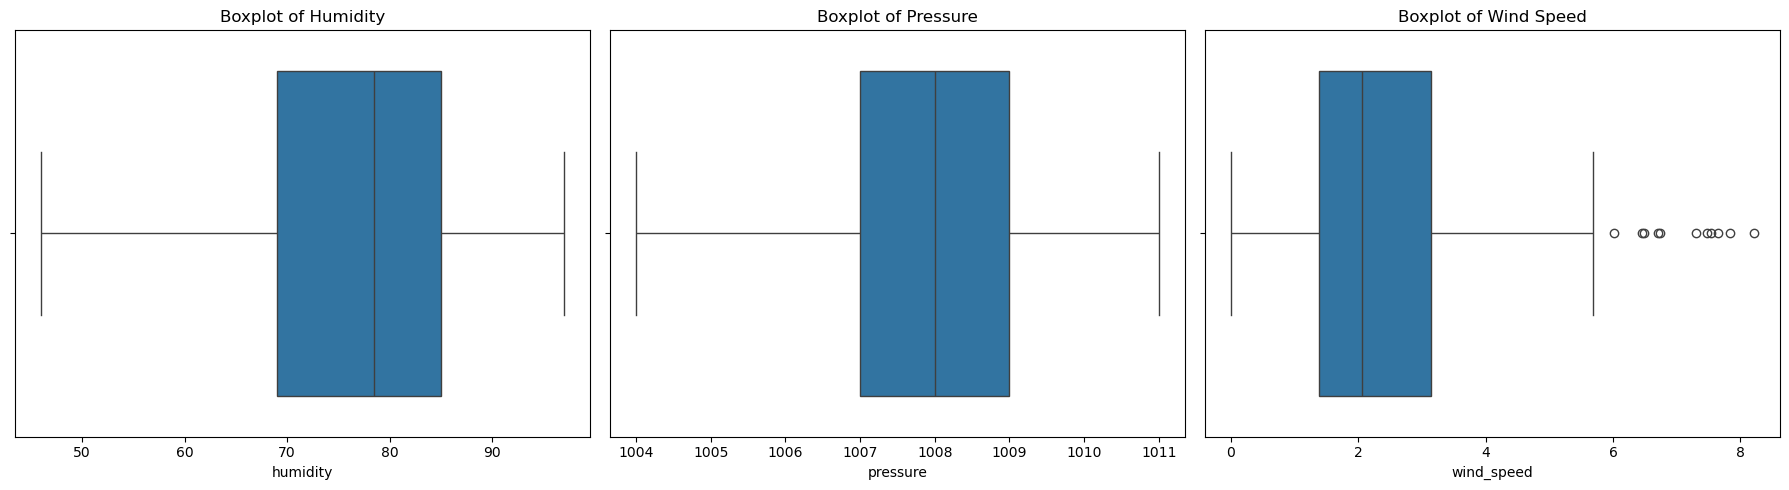

In [ ]:
# Cek outlier pada data numerik
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 baris, 3 kolom

sns.boxplot(x='humidity', ax=axes[0], data=df, orient='h')
axes[0].set_title('Boxplot of Humidity')

sns.boxplot(x='pressure', ax=axes[1], data=df, orient='h')
axes[1].set_title('Boxplot of Pressure')

sns.boxplot(x='wind_speed', ax=axes[2], data=df, orient='h')
axes[2].set_title('Boxplot of Wind Speed')

plt.tight_layout()
plt.show()

Karena ada fitur yang punya outlier, maka RobustScaler jadi pilihan yang paling tepat agar lebih aman dan konsisten (outlier tidak dihapus karena masih dalam batas yang masuk akal, juga agar model tetap bisa memprediksi kasus ekstrem).

Sedangkan pada fitur waktu seperti hour dan weekday, sifatnya siklikal (misal jam 23 dan 0 sebenarnya dekat secara waktu namun jauh secara angka). Model mungkin akan sulit menangkap pola siklikal ini, sehingga lebih baik jika mengubahnya ke siklikal menggunakan transformasi trigonometri (sin & cos).

In [16]:
# Ubah hour dan weekday ke bentuk trigonometri
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, hour_col='hour', weekday_col='weekday'):
        self.hour_col = hour_col
        self.weekday_col = weekday_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        # Buat fitur siklikal untuk hour
        X_['hour_sin'] = np.sin(2 * np.pi * X_[self.hour_col] / 24)
        X_['hour_cos'] = np.cos(2 * np.pi * X_[self.hour_col] / 24)
        # Buat fitur siklikal untuk weekday
        X_['weekday_sin'] = np.sin(2 * np.pi * X_[self.weekday_col] / 7)
        X_['weekday_cos'] = np.cos(2 * np.pi * X_[self.weekday_col] / 7)
        # Drop kolom asli
        return X_.drop(columns=[self.hour_col, self.weekday_col])

In [17]:
# Preprocessing dengan pipeline
preprocessor = Pipeline([
    ('cyclical', CyclicalFeatures()),
    ('column_transform', ColumnTransformer([
        ('num', RobustScaler(), ['humidity', 'pressure', 'wind_speed']),
        ('cyclical_passthrough', 'passthrough', ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['city', 'weather_desc'])
    ]))
])

In [18]:
# Benchmarking Model pada data train 
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1)
xgb = XGBRegressor(random_state=1)

def evaluate_models(X, y, models, model_names, preprocessor= preprocessor, n_splits=5, random_state=42):

    metrics = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']
    metric_names = ['RMSE', 'MAE', 'R2']

    results = []

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for model, name in zip(models, model_names):
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        row = {'Model': name}

        for metric, mname in zip(metrics, metric_names):
            scores = cross_val_score(pipeline, X, y, cv=cv, scoring=metric)
            if metric.startswith('neg_'):
                scores = -scores
            row[f'{mname} Mean'] = np.mean(scores)
            row[f'{mname} Std'] = np.std(scores)

        results.append(row)

    return pd.DataFrame(results)

models = [lr, knn, dt, rf, xgb]
model_names = ['Linear Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost']

df_eval = evaluate_models(X_train, y_train, models, model_names, preprocessor=preprocessor).round(3).sort_values(by='RMSE Mean', ascending=True)
print(df_eval)

               Model  RMSE Mean  RMSE Std  MAE Mean  MAE Std  R2 Mean  R2 Std
3      Random Forest      0.911     0.150     0.635    0.079    0.889   0.029
4            XGBoost      0.988     0.193     0.656    0.071    0.868   0.046
0  Linear Regression      1.049     0.101     0.791    0.071    0.853   0.018
1                KNN      1.142     0.206     0.845    0.138    0.821   0.059
2      Decision Tree      1.353     0.333     0.874    0.211    0.749   0.111


Berdasarkan hasil evaluasi benchmarking model pada data train menggunakan cross-validation, Random Forest menunjukkan performa terbaik dengan akurasi tinggi dan variasi performa yang rendah. Oleh karena itu, model ini dipilih untuk digunakan dalam proses prediksi pada data test.

In [19]:
# Prediksi ke data test
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf)
])
pipeline.fit(X_train, y_train) # fit ulang di seluruh data training
y_pred = pipeline.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

RMSE: 0.6324931962084688
MAE: 0.501652500000003
R²: 0.9413343126525601


Hasil evaluasi :
- RMSE: 0.632 → prediksi suhu rata-rata meleset sekitar 0.63 derajat Celcius
- MAE: 0.501 → rata-rata deviasi absolut dari suhu aktual sekitar 0.5 derajat Celcius
- R²: 0.941 → sekitar 94% variasi suhu bisa dijelaskan oleh fitur dalam model

Hasil ini menunjukkan bahwa model yang dilatih sudah cukup akurat (RMSE dan MAE dibawah 1 derajat Celcius), mampu generalisasi dengan baik (R² tinggi di data test), dan cukup stabil karena mirip dengan hasil di data train. 

In [26]:
# Hyperparameter Tuning (dicoba lebih dulu di data train untuk memilih hyperparameter)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf)
])
param_grid = {
    'model__n_estimators': [100, 200],         # jumlah pohon
    'model__max_depth': [None, 10, 20],        # kedalaman pohon
    'model__min_samples_split': [2, 5],        # minimal sample untuk split
    'model__min_samples_leaf': [1, 2],         # minimal sample di daun
    'model__max_features': ['sqrt', 'log2'],   # jumlah fitur tiap split
    'model__bootstrap': [True, False]          # bootstrap samples
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_tuning = best_model.predict(X_test)

print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_tuning)))
print("Test MAE:", mean_absolute_error(y_test, y_pred_tuning))
print("Test R²:", r2_score(y_test, y_pred_tuning))

Best parameters: {'model__bootstrap': False, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Test RMSE: 0.5070900826036701
Test MAE: 0.38203999999999744
Test R²: 0.962291202705369


| **Metrik**   | **Sebelum Tuning** | **Setelah Tuning** |
| ------------ | ------------------ | ------------------ |
| **RMSE**     | 0.632             | 0.507             |
| **MAE**      | 0.501             | 0.382             |
| **R² Score** | 0.941             | 0.962             |

Berdasarkan hasil tersebut, tuning berhasil meningkatkan performa model secara signifikan, sehingga hasil model setelah tuning yang jadi model finalnya.

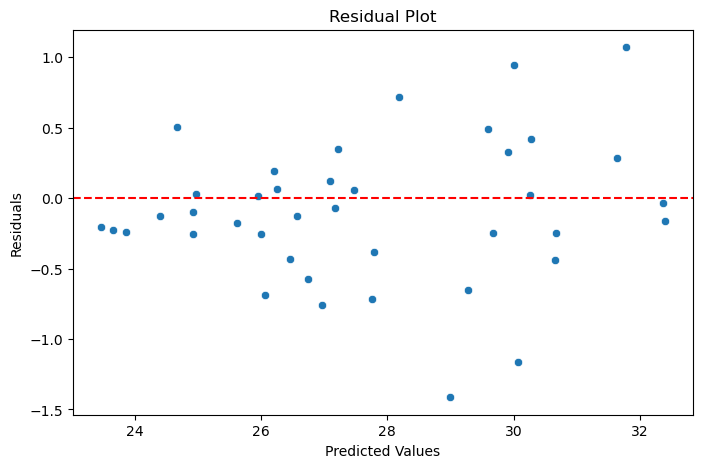

In [27]:
# Visualisasi residual plot
residuals = y_test - y_pred_tuning

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_tuning, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

Kesimpulan :
- Titik residual tersebar acak, kebanyakan di sekitar garis horizontal (residual=0), dan tidak terlihat ada pola khusus yang terbentuk. Model tidak melewatkan pola penting.
- Variasi residual cenderung konsisten, penyebaran residual tidak banyak berubah seiring naiknya nilai prediksi. Artinya, tidak ada indikasi kuat akan heteroskedastisitas (variasi error yang berubah-ubah). Model cukup stabil.
- Ada beberapa outlier yang agak jauh dr garis nol (<-1), namun jumlahnya sangat kecil dan tidak mempengaruhi model secara signifikan, terutama karena model yang digunakan adalah Random Forest. Selain itu, outlier ini mewakili fenomena asli, sehingga tidak perlu dihapus maupun diubah.

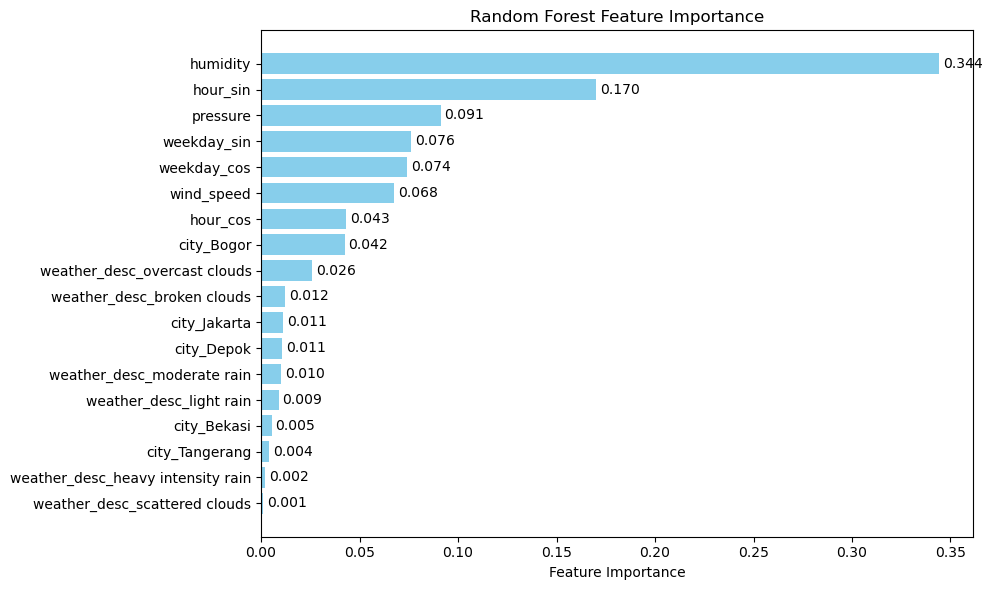

In [31]:
# Feature Importance
column_transformer = preprocessor.named_steps['column_transform']
rf_model = best_model.named_steps['model']

num_features = ['humidity', 'pressure', 'wind_speed']
cat_features = ['city', 'weather_desc']
cyclical_features = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']  # sudah hasil akhir dari CyclicalFeatures

num_out = column_transformer.named_transformers_['num'].get_feature_names_out(num_features)
cat_out = column_transformer.named_transformers_['cat'].get_feature_names_out(cat_features)
cyclical_out = cyclical_features  # karena 'passthrough', nama tetap

all_features = list(num_out) + list(cyclical_out) + list(cat_out)

feat_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(feat_importance['Feature'], feat_importance['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # agar fitur paling penting di atas

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center')

plt.tight_layout()
plt.show()

Berdasarkan grafik, kelembaban adalah fitur terpenting. Faktor waktu (jam, hari) dan tekanan juga sangat berpengaruh. Sementara itu, kota dan detail deskripsi cuaca kurang penting dalam model ini.

#### Kesimpulan

Berdasarkan analisis dan pembangunan model prediksi suhu harian menggunakan data iklim, dapat disimpulkan bahwa:
- Model Random Forest yang dibangun berhasil memprediksi suhu harian dengan sangat baik, ditunjukkan oleh nilai RMSE 0.5071 dan MAE 0.3820 setelah tuning, serta R² sebesar 0.9623 pada data test. Ini menunjukkan model mampu menjelaskan lebih dari 96% variasi suhu berdasarkan fitur iklim yang tersedia.
- Residual plot menunjukkan distribusi residual yang acak dan tidak ada pola khusus, menandakan model tidak melewatkan pola penting dan cukup stabil tanpa indikasi heteroskedastisitas.
- Outlier yang muncul merupakan fenomena nyata dan jumlahnya kecil sehingga tidak mengganggu performa model.
- Fitur kelembaban menjadi faktor paling signifikan dalam memprediksi suhu, diikuti oleh variabel waktu (jam, hari) dan tekanan udara. Sedangkan fitur kategori seperti kota dan deskripsi cuaca memberikan kontribusi yang lebih kecil.

Dengan performa prediksi yang akurat dan stabil, model ini sangat dapat diandalkan untuk mendukung keputusan perencanaan acara pernikahan oleh Anita Weddings.

#### Rekomendasi

Berdasarkan hasil dan kesimpulan yang diperoleh, berikut adalah rekomendasi untuk Anita Weddings:
- Pemanfaatan Prediksi Suhu untuk Pengambilan Keputusan Lokasi :
    - Gunakan prediksi suhu harian sebagai dasar utama dalam merekomendasikan lokasi acara (indoor atau outdoor) kepada klien. Misalnya, jika suhu diprediksi tinggi, rekomendasi untuk acara indoor atau outdoor dengan tenda ber-AC dapat diberikan.
    - Integrasikan hasil prediksi ke dalam proses konsultasi awal dengan klien untuk memberikan saran yang lebih informatif dan berbasis data.

- Optimalisasi Persiapan Perlengkapan :
    - Manfaatkan prediksi suhu untuk menentukan kebutuhan perlengkapan tambahan seperti kipas angin, air cooler, atau pemanas ruangan agar kenyamanan tamu tetap terjaga dan acara berjalan lancar meskipun terjadi perubahan suhu ekstrim.

- Integrasi Sistem :
    - Pertimbangkan untuk mengintegrasikan model prediksi ini ke dalam sistem perencanaan atau dashboard internal Anita Weddings. Hal ini akan memudahkan tim untuk mengakses dan menggunakan data prediksi secara real-time.
    - Automatisasi pengambilan data iklim dari API dan feeding ke model untuk mendapatkan prediksi terbaru secara berkala.

- Monitoring dan Pemeliharaan Model:
    - Lakukan monitoring berkala terhadap performa model di lapangan. Bandingkan prediksi dengan suhu aktual setelah acara berlangsung untuk memastikan akurasi tetap terjaga.
    - Jadwalkan retraining model secara berkala (misalnya setiap 6-12 bulan) dengan data terbaru untuk memastikan model tetap relevan dengan perubahan pola iklim yang mungkin terjadi.

- Eksplorasi Fitur Tambahan:
    - Meskipun fitur yang ada sudah cukup baik, eksplorasi lebih lanjut terhadap fitur lain seperti indeks UV, visibilitas, atau data polusi udara dapat dipertimbangkan jika relevan dengan kenyamanan acara dan tersedia datanya.
    - Pertimbangkan untuk menambahkan fitur kalender khusus (misalnya, hari libur nasional, musim liburan) yang mungkin memengaruhi pola suhu atau preferensi acara.

Dengan mengimplementasikan rekomendasi ini, Anita Weddings dapat meningkatkan efisiensi operasional, mengurangi risiko gangguan acara akibat cuaca, dan pada akhirnya meningkatkan kepuasan klien dengan perencanaan yang lebih matang dan adaptif.

In [23]:
# Save model

with open('best_model_random_forest.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model terbaik hasil tuning berhasil disimpan ke 'best_model_random_forest.pkl'!")

Model terbaik hasil tuning berhasil disimpan ke 'best_model_random_forest.pkl'!


In [24]:
# # Untuk memuat kembali model
# with open('best_model_random_forest.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Contoh prediksi setelah load model
# y_loaded_pred = loaded_model.predict(X_test)
# print("Prediksi dari model yang dimuat kembali berhasil dilakukan!")